In [ ]:
import numpy as np

import qcodes as qc

## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)

## Dummy instruments for generating synthetic data
from qcodes.instrument_drivers.mock_instruments import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)

## Using interactive widget
from qcodes.interactive_widget import experiments_widget
from qcodes_contrib_drivers.drivers.QuTech.IVVI import IVVI

# A dummy signal generator with two parameters ch1 and ch2
dac = IVVI("dac", "COM1", numdacs=4, dac_delay=0.005)

In [5]:
# A dummy digital multimeter that generates a synthetic data depending
# on the values set on the setter_instr, in this case the dummy dac

dmm.print_readable_snapshot()

dmm:
	parameter value
--------------------------------------------------------------------------------
IDN :	None 
v1  :	0 (V)
v2  :	0 (V)


In [ ]:
station = qc.Station()
station.add_component(dac)
station.add_component(dmm)

In [8]:
station.snapshot()

{'instruments': {'dac': {'functions': {},
   'submodules': {},
   'parameters': {'IDN': {'__class__': 'qcodes.parameters.parameter.Parameter',
     'full_name': 'dac_IDN',
     'value': {'vendor': 'QCoDeS',
      'model': "<class 'qcodes.instrument_drivers.mock_instruments.DummyInstrument'>",
      'serial': 'NA',
      'firmware': 'NA'},
     'raw_value': {'vendor': 'QCoDeS',
      'model': "<class 'qcodes.instrument_drivers.mock_instruments.DummyInstrument'>",
      'serial': 'NA',
      'firmware': 'NA'},
     'ts': '2024-11-27 11:27:35',
     'inter_delay': 0,
     'unit': '',
     'label': 'IDN',
     'vals': '<Anything>',
     'post_delay': 0,
     'validators': ['<Anything>'],
     'instrument': 'qcodes.instrument_drivers.mock_instruments.DummyInstrument',
     'instrument_name': 'dac',
     'name': 'IDN'},
    'ch1': {'__class__': 'qcodes.parameters.parameter.Parameter',
     'full_name': 'dac_ch1',
     'value': 0,
     'raw_value': 0,
     'ts': '2024-11-27 11:27:35',
     'i

In [23]:
initialise_or_create_database_at("~/experiments_for_15_mins.db")

In [11]:
qc.config.core.db_location

'~/experiments_for_15_mins.db'

In [12]:
tutorial_exp = load_or_create_experiment(
    experiment_name="tutorial_exp", sample_name="synthetic data"
)

In [24]:
from local_qcodes.measurements.IV import IV_measurement


context_meas = IV_measurement("~/experiments_for_15_mins.db", "test_sample", station)

In [14]:
# Register the independent parameter...
context_meas.register_parameter(dac.ch1)
# ...then register the dependent parameter
context_meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

In [15]:
# Time for periodic background database writes
context_meas.write_period = 2

with context_meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v), (dmm.v1, get_v))

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 1. 


In [17]:
# Setting up a doNd measurement
sweep_1 = LinSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_2 = LinSweep(dac.ch2, -1, 1, 20, 0.01)
dond(
    sweep_1,  # 1st independent parameter
    sweep_2,  # 2nd independent parameter
    dmm.v1,  # 1st dependent parameter
    dmm.v2,  # 2nd dependent parameter
    measurement_name="dond_example",  # Set the measurement name
    exp=tutorial_exp,  # Set the experiment to save data to.
    show_progress=True,  # Optional progress bar
)

Starting experimental run with id: 3. Using 'qcodes.dataset.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

(dond_example #3@C:\Users\mpdubbelman\experiments_for_15_mins.db
 ---------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 (None,),
 (None,))

In [18]:
experiments()

[tutorial_exp#synthetic data#1@C:\Users\mpdubbelman\experiments_for_15_mins.db
 -----------------------------------------------------------------------------
 1-context_example-1-dac_ch1,dmm_v1-10
 2-dond_example-2-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800
 3-dond_example-3-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800]

In [19]:
tutorial_exp.data_sets()

[context_example #1@C:\Users\mpdubbelman\experiments_for_15_mins.db
 ------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 dond_example #2@C:\Users\mpdubbelman\experiments_for_15_mins.db
 ---------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 dond_example #3@C:\Users\mpdubbelman\experiments_for_15_mins.db
 ---------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric]

In [20]:
dataset_1d = load_by_run_spec(experiment_name="tutorial_exp", captured_run_id=1)
dataset_2d = load_by_run_spec(experiment_name="tutorial_exp", captured_run_id=2)

([<Axes: title={'center': 'Run #1, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

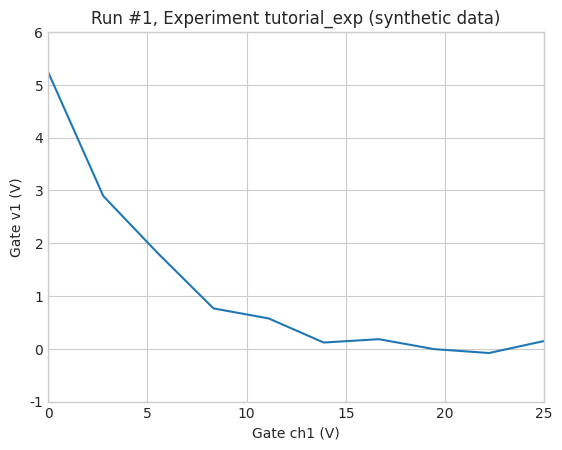

In [21]:
# Plotting 1d dataset
plot_dataset(dataset_1d)

([<Axes: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <Axes: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x27dc8cbc7a0>])

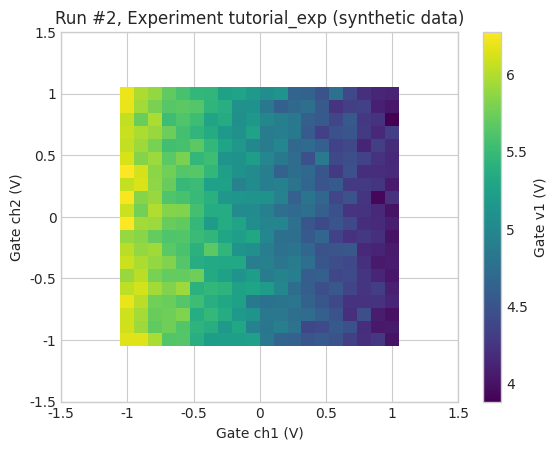

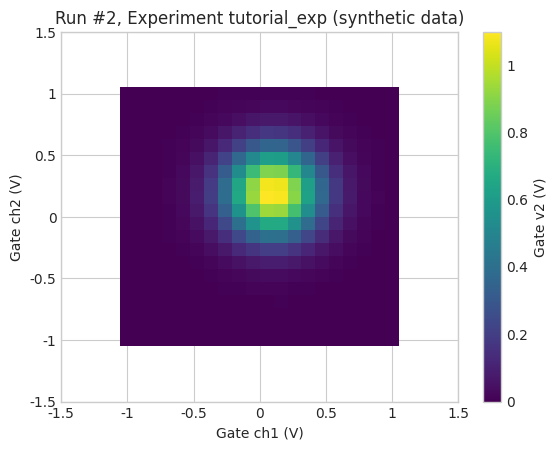

In [22]:
# Plotting 2d dataset as heatmaps
plot_dataset(dataset_2d)

